<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_stabilize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders on Tabular Data

* Losses
   * https://keras.io/losses/
   * Predefined loss functions: https://github.com/keras-team/keras/blob/master/keras/losses.py
   * Example custom loss function: https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
   * Loss function that is not f(y_true, y_pred): https://github.com/keras-team/keras/issues/2662
* Having more than one input/output, combined losses: https://keras.io/getting-started/functional-api-guide/
* Normalizaing data: https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize   

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  39271      0 --:--:-- --:--:-- --:--:-- 39328


In [0]:
import pandas as pd

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [5]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [6]:
sns.pairplot?

Object `sns.pairplot` not found.


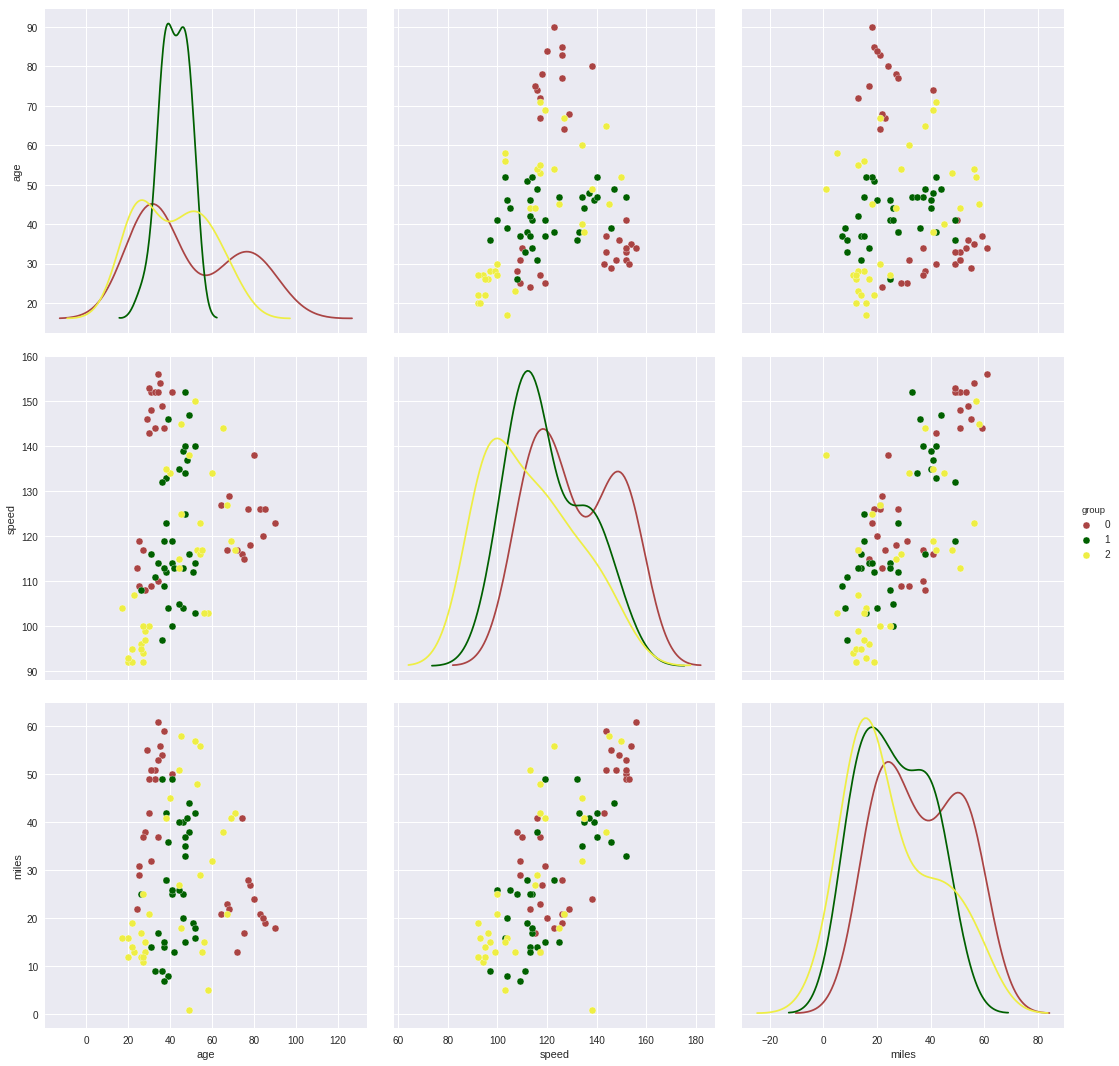

In [7]:
import seaborn as sns

sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, 
             hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'},
#              kind='reg',
             size=5,
             diag_kind='kde',
             vars=['age', 'speed', 'miles'])

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

encoding_dim = 32

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
encoder (Dense)              (None, 32)                160       
_________________________________________________________________
decoder (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


In [9]:
X = df
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 794.3408
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 26.6884
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 3.4848
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.5778
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3111
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1874
Epoch 7/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1035
Epoch 8/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0522
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0263
Epoch 10/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0158
CPU times: user 31.3 s, sys: 4.85 s, total: 36.1 s
Wall time: 27 s


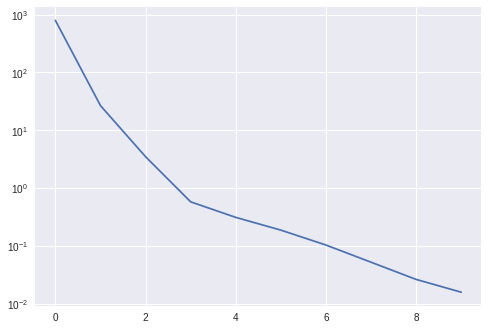

In [10]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [11]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 756us/step


0.006468222198852648

In [12]:
samples = df.sample(10).reset_index(drop=True)
samples

,speed,age,miles,group
0,129.0,86.0,19.0,0
1,90.0,45.0,16.0,1
2,149.0,49.0,42.0,1
3,133.0,25.0,13.0,0
4,112.0,90.0,30.0,0
5,106.0,63.0,18.0,2
6,113.0,18.0,33.0,0
7,149.0,64.0,43.0,2
8,163.0,54.0,34.0,2
9,116.0,32.0,26.0,0


In [13]:
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,128.961258,85.923576,18.900248,-0.006706
1,90.151421,45.061462,16.059481,0.949445
2,148.886597,48.882580,42.045868,0.945923
3,132.866119,24.942982,13.047067,0.081237
4,112.042259,90.348137,29.915968,0.101176
5,106.085358,62.973957,18.047056,1.878531
6,113.032661,18.036285,33.063389,0.029089
7,148.907516,63.850685,43.039570,1.865696
8,162.786240,53.795361,34.029854,1.910720
9,116.012772,32.013981,26.059599,0.028782


In [14]:
samples.subtract(predictions)

,speed,age,miles,group
0,0.038742,0.076424,0.099752,0.006706
1,-0.151421,-0.061462,-0.059481,0.050555
2,0.113403,0.117420,-0.045868,0.054077
3,0.133881,0.057018,-0.047067,-0.081237
4,-0.042259,-0.348137,0.084032,-0.101176
5,-0.085358,0.026043,-0.047056,0.121469
6,-0.032661,-0.036285,-0.063389,-0.029089
7,0.092484,0.149315,-0.039570,0.134304
8,0.213760,0.204639,-0.029854,0.089280
9,-0.012772,-0.013981,-0.059599,-0.028782


## Looks quite nice, but how impressed are you by abstracting 4 variables into 32?

Let us try dimension of 2

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3807.0403
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2421.8394
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1552.2815
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 982.8292
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 612.8808
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 391.1961
Epoch 7/10
1500/1500 [==============================] - 2s 2ms/step - loss: 275.2887
Epoch 8/10
1500/1500 [==============================] - 2s 2ms/step - loss: 226.8419
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 212.5567
Epoch 10/10
1500/1500 [==============================] - 2s 2ms/step - loss: 209.5767
CPU times: user 31.3 s, sys: 4.57 s, total: 35.8 s
Wall time: 25.5 s


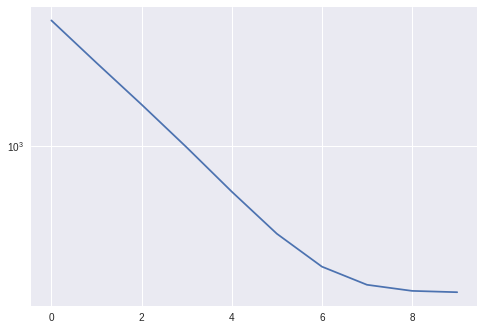

In [15]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='tanh', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# this does not get much better than 210 as a loss (bad), so we can just as well get there a bit faster (10 instead of 50 epochs with standard lr)
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [16]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 789us/step


209.12026048787436

In [17]:
# just average over all of them :D
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,122.033234,45.417992,30.331961,0.90692
1,122.033234,45.417992,30.331961,0.90692
2,122.033234,45.417992,30.331961,0.90692
3,122.033234,45.417992,30.331961,0.90692
4,122.033234,45.417992,30.331961,0.90692
5,122.033234,45.417992,30.331961,0.90692
6,122.033234,45.417992,30.331961,0.90692
7,122.033234,45.417992,30.331961,0.90692
8,122.033234,45.417992,30.331961,0.90692
9,122.033234,45.417992,30.331961,0.90692


In [18]:
samples.describe()

,speed,age,miles,group
count,10.000000,10.000000,10.000000,10.000000
mean,126.000000,52.600000,27.400000,0.800000
std,22.720524,24.056415,10.731056,0.918937
min,90.000000,18.000000,13.000000,0.000000
25%,112.250000,35.250000,18.250000,0.000000
50%,122.500000,51.500000,28.000000,0.500000
75%,145.000000,63.750000,33.750000,1.750000
max,163.000000,90.000000,43.000000,2.000000


### relu makes it train

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 4201.1962
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 238.5806
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 130.4345
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 118.9675
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 114.3226
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.6420
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.6160
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.3991
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.6266
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.2347
CPU times: user 1min, sys: 8.7 s, total: 1min 9s
Wall time: 49 s


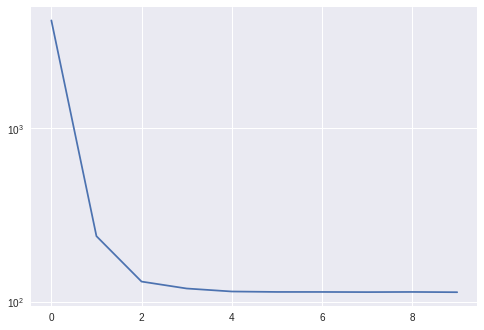

In [19]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [20]:
samples

,speed,age,miles,group
0,129.0,86.0,19.0,0
1,90.0,45.0,16.0,1
2,149.0,49.0,42.0,1
3,133.0,25.0,13.0,0
4,112.0,90.0,30.0,0
5,106.0,63.0,18.0,2
6,113.0,18.0,33.0,0
7,149.0,64.0,43.0,2
8,163.0,54.0,34.0,2
9,116.0,32.0,26.0,0


In [21]:
# all groups close to 1, all off as they might not add to a big error
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,137.571930,50.578327,35.464401,0.954679
1,92.477554,34.019840,23.293760,1.076675
2,147.884766,54.365166,38.247761,0.926779
3,120.902443,44.457355,30.965427,0.999776
4,127.444267,46.859489,32.731018,0.982078
5,111.400162,40.968151,28.400833,1.025483
6,107.057762,39.373638,27.228851,1.037231
7,152.596542,56.095314,39.519436,0.914032
8,158.911209,58.414032,41.223713,0.896948
9,112.148987,41.243118,28.602936,1.023457


### Let's try normalizing the data first (caution: losses do not compare any more)

In [22]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
normalized_df = (df - df.mean()) / df.std()
normalized_df.head()

,speed,age,miles,group
0,-1.391286,-0.057247,-0.356309,0.001632
1,-0.255202,0.526510,-0.421879,0.001632
2,-0.652832,-1.108011,0.233824,-1.222706
3,-1.448090,-1.166386,-1.339863,1.225971
4,-0.482419,-0.407502,-0.553020,0.001632


Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.8163
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6173
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5150
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4154
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3622
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3378
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3271
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3212
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3186
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3166
CPU times: user 1min 1s, sys: 8.68 s, total: 1min 9s
Wall time: 49.6 s


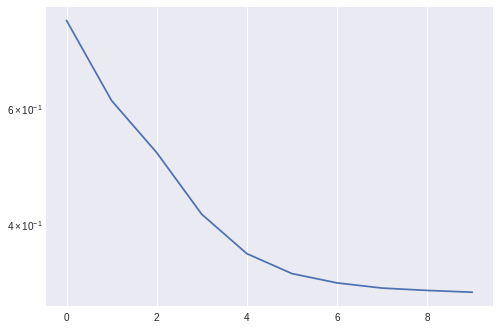

In [23]:
X = normalized_df
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

## This makes it very hard to estimate how well we did our job, but we can still plot the embedding

Could be interpreted as a fancy version of dimensionality reduction


In [0]:
encoder = Model(inputs=input_data, outputs=encoded)
latent_representation = encoder.predict(X)

In [25]:
latent_representation.shape

(1500, 2)

### Look, ma, clusters

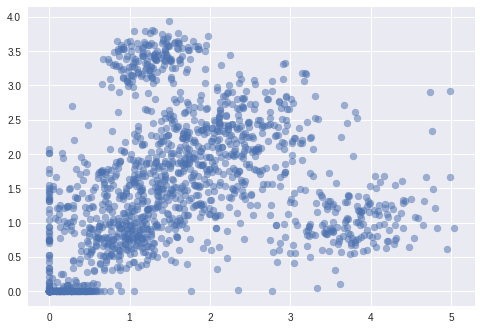

In [26]:
latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]
plt.scatter(latent_x, latent_y, alpha=0.5)

### Clusters have actual meaning

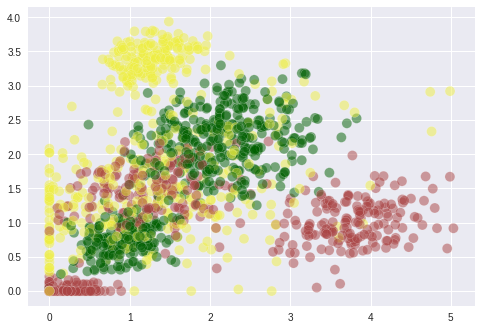

In [27]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

## But color still was not encoded properly: one-hot

In [0]:
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
one_hot_groups = pd.DataFrame(to_categorical(df['group']), columns={'red', 'green', 'yellow'})
main = df.drop('group', axis='columns')

In [29]:
main.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [30]:
one_hot_groups.head()

,green,red,yellow
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


### Challenge: we could feed in both parts in a united way, but they need different loss functions

* write a custom loss function that does this and balances the value: https://keras.io/losses/
* create multi-in/out model that makes this a little bit more transparent: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

In [31]:
from tensorflow.keras.layers import concatenate, average, add

# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder")(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder")(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output")(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output")(encoded)

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])

adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
group_input (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
main_encoder (Dense)            (None, 2)            8           main_input[0][0]                 
__________________________________________________________________________________________________
group_encoder (Dense)           (None, 2)            8           group_input[0][0]                
__________________________________________________________________________________________________
concatenat

In [32]:
BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': main, 'group_input': one_hot_groups},\
    y={'main_output': main, 'group_output': one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 10s 7ms/step - loss: 53829.4281 - main_output_loss: 102.4435 - group_output_loss: 10.7454
Epoch 2/10
1500/1500 [==============================] - 10s 6ms/step - loss: 53777.3653 - main_output_loss: 50.3807 - group_output_loss: 10.7454
Epoch 3/10
1500/1500 [==============================] - 10s 6ms/step - loss: 53777.8656 - main_output_loss: 50.8811 - group_output_loss: 10.7454
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 53776.8517 - main_output_loss: 49.8672 - group_output_loss: 10.7454
Epoch 5/10
1500/1500 [==============================] - 10s 7ms/step - loss: 53776.6007 - main_output_loss: 49.6161 - group_output_loss: 10.7454
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 53775.4163 - main_output_loss: 48.4317 - group_output_loss: 10.7454
Epoch 7/10
1500/1500 [==============================] - 10s 7ms/step - loss: 53774.5683 - main_output_loss: 47.5838 - group_outpu

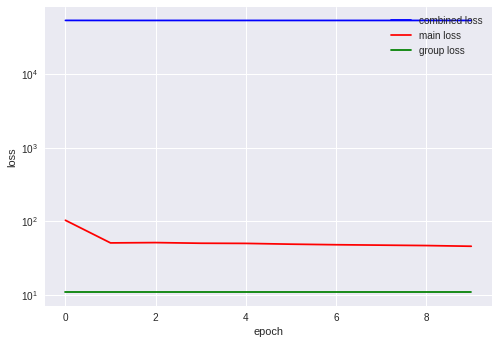

In [33]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')


In [0]:
samples = df.sample(10).reset_index(drop=True)
main_samples = samples.drop('group', axis='columns')
group_samples = pd.DataFrame(to_categorical(samples['group']), columns={'red', 'green', 'yellow'})

In [35]:
merged_samples = pd.concat([main_samples, group_samples], axis=1)
merged_samples

,speed,age,miles,green,red,yellow
0,149.0,33.0,44.0,1.0,0.0,0.0
1,123.0,43.0,44.0,0.0,0.0,1.0
2,93.0,20.0,10.0,0.0,0.0,1.0
3,133.0,16.0,23.0,1.0,0.0,0.0
4,129.0,35.0,1.0,0.0,0.0,1.0
5,127.0,32.0,12.0,0.0,1.0,0.0
6,121.0,65.0,29.0,0.0,0.0,1.0
7,115.0,29.0,21.0,0.0,1.0,0.0
8,115.0,41.0,26.0,0.0,1.0,0.0
9,119.0,100.0,22.0,1.0,0.0,0.0


In [36]:
autoencoder.predict([main_samples, group_samples])

[array([[150.48041 ,  33.473442,  44.607166],
        [129.60336 ,  40.82669 ,  33.50637 ],
        [ 89.70347 ,  22.780294,  20.3653  ],
        [127.68963 ,  19.893658,  37.923985],
        [118.66391 ,  42.947884,  28.125267],
        [120.50583 ,  37.39624 ,  30.337963],
        [125.091385,  65.563736,  25.284496],
        [113.18556 ,  31.3271  ,  28.620853],
        [116.28298 ,  42.037155,  27.299316],
        [124.84342 , 101.33752 ,  16.17585 ]], dtype=float32),
 array([[2.0804212e-38, 1.0000000e+00, 0.0000000e+00],
        [1.3932361e-33, 1.0000000e+00, 0.0000000e+00],
        [1.3272840e-22, 1.0000000e+00, 1.7303819e-33],
        [5.8649633e-32, 1.0000000e+00, 0.0000000e+00],
        [5.8543930e-31, 1.0000000e+00, 0.0000000e+00],
        [4.0727687e-31, 1.0000000e+00, 0.0000000e+00],
        [8.3338775e-34, 1.0000000e+00, 0.0000000e+00],
        [5.9568995e-29, 1.0000000e+00, 0.0000000e+00],
        [2.5914093e-30, 1.0000000e+00, 0.0000000e+00],
        [1.0621107e-35, 1.00

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encoded)
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

In [38]:
latent_representation.shape

(1500, 2)

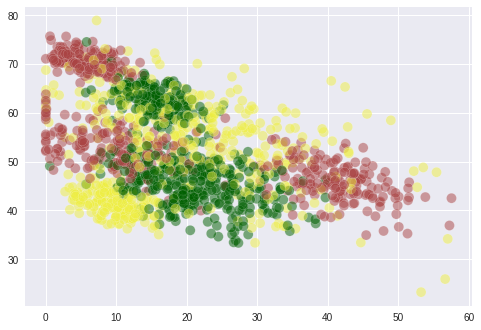

In [39]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### What a funny result: trained to (sometims almost) perfectly reproduce the groups, but not much of anything else

quite obviously we ware emphasizing the group loss way too much

## Making results more stable

* when you visualize latent spaces they should not change much when re-training or fitting additional data points
* when working with autoencoders or embeddings there are two ways to make that happen
  1. save model, do not retrain from scratch and only fit new data points with low learning rate
  1. save output from embedding and keep new latent space similar by adding to the loss function

### Option I: Saving and reloading model, retrain
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [0]:
# save complete model
autoencoder.save('autoencoder-v1.h5')
del autoencoder

In [0]:
# later...
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encode)

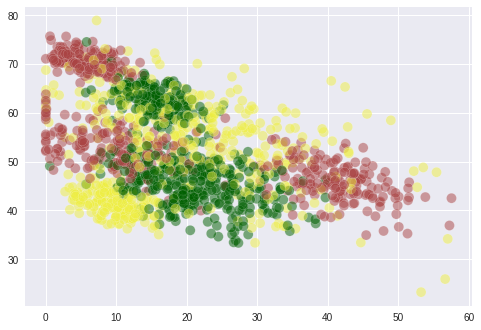

In [44]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Using new dataset

In [45]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-300.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5376  100  5376    0     0  15765      0 --:--:-- --:--:-- --:--:-- 15719


In [0]:
import pandas as pd

new_df = pd.read_csv('./insurance-customers-300.csv', sep=';')
new_one_hot_groups = pd.DataFrame(to_categorical(new_df['group']), columns={'red', 'green', 'yellow'})
new_main = new_df.drop('group', axis='columns')

In [47]:
new_main.head()

,speed,age,miles
0,117.0,41.0,5.0
1,108.0,18.0,15.0
2,107.0,28.0,14.0
3,111.0,43.0,62.0
4,129.0,36.0,42.0


In [48]:
new_one_hot_groups.head()

,green,red,yellow
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [50]:
#default lr
# adam = keras.optimizers.Adam(lr=0.001)
# we use just half of that
adam = keras.optimizers.Adam(lr=0.0005)
# even this high learning rate can not break it (moves it quite a bit, but still same overall shape)
# adam = keras.optimizers.Adam(lr=0.1)

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)


Epoch 1/10
300/300 [==============================] - 3s 8ms/step - loss: 53772.0222 - main_output_loss: 45.0375 - group_output_loss: 10.7454
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 53771.4558 - main_output_loss: 44.4713 - group_output_loss: 10.7454
Epoch 3/10
300/300 [==============================] - 2s 6ms/step - loss: 53771.2788 - main_output_loss: 44.2941 - group_output_loss: 10.7454
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 53771.0126 - main_output_loss: 44.0280 - group_output_loss: 10.7454
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 53770.8517 - main_output_loss: 43.8669 - group_output_loss: 10.7454
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 53770.7356 - main_output_loss: 43.7511 - group_output_loss: 10.7454
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 53770.6356 - main_output_loss: 43.6510 - group_output_loss: 10.7454
Epoch 

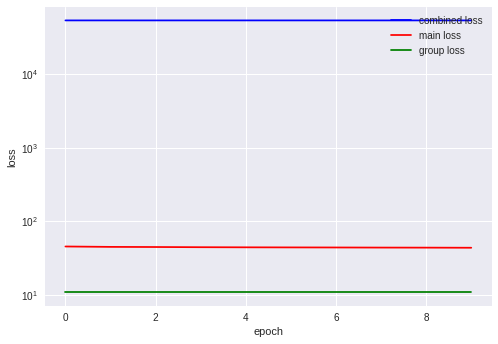

In [51]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')


In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

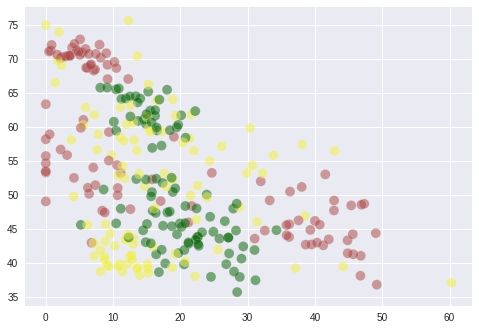

In [53]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Old data

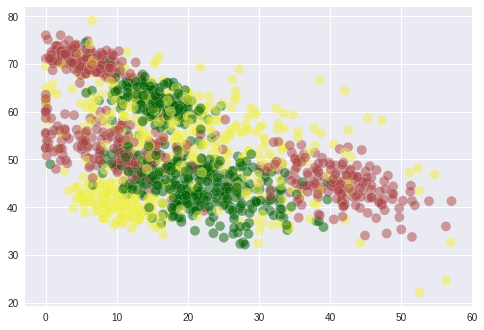

In [54]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Option II: Train from scratch, but use difference to original latent representation as part of loss function


In [0]:
# start over from scratch
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

In [0]:
new_original_latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
old_original_latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

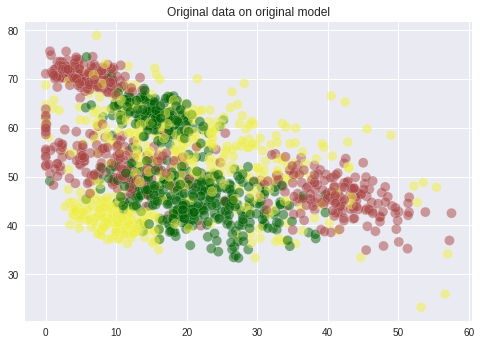

In [73]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('Original data on original model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

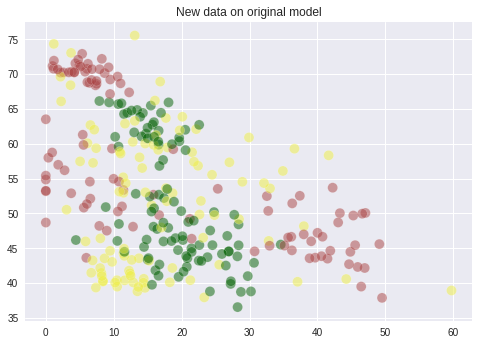

In [74]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('New data on original model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

In [0]:
# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder")(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder")(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output")(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output")(encoded)
stability_output = encoded # just the latent space as output

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output, stability_output])

In [76]:
# adam = keras.optimizers.Adam(lr=0.001)
adam = keras.optimizers.Adam(lr=0.01)

# note: main_output also changed to mae to make it smaller in relation to the others
autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mae', 'group_output': 'categorical_crossentropy', 'encoder': 'mae' },
              loss_weights={'main_output': 1., 'group_output': 1., 'encoder': 1.})

BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups, 'encoder': new_original_latent_representation},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)


Epoch 1/10
300/300 [==============================] - 3s 11ms/step - loss: 68.8046 - main_output_loss: 39.4528 - group_output_loss: 1.3225 - encoder_loss: 28.0293
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 35.2809 - main_output_loss: 13.8946 - group_output_loss: 1.2732 - encoder_loss: 20.1130
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 31.8253 - main_output_loss: 13.8166 - group_output_loss: 1.3093 - encoder_loss: 16.6995
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 26.7834 - main_output_loss: 13.5984 - group_output_loss: 1.3667 - encoder_loss: 11.8183
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 24.1928 - main_output_loss: 13.6781 - group_output_loss: 1.3543 - encoder_loss: 9.1604
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 23.9043 - main_output_loss: 13.6032 - group_output_loss: 1.4439 - encoder_loss: 8.8572
Epoch 7/10
300/300 [=========

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

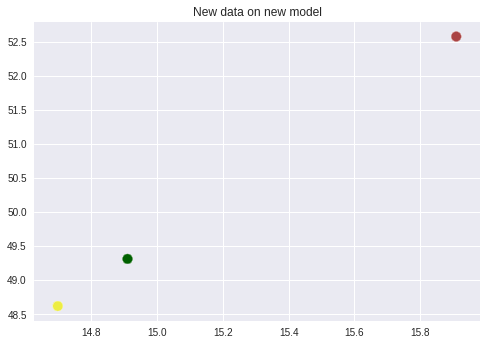

In [80]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.title('New data on new model')

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)